<a href="https://colab.research.google.com/github/harmanjeet27/spam-email/blob/main/spam_or_ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

In [3]:
# Dataset URL (direct link, no download needed)
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"

# Load the dataset
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])


In [4]:
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df['label'].value_counts()

,count
label,
ham,4825
spam,747


In [6]:
import nltk
nltk.download('punkt')       # for tokenization
nltk.download('stopwords')   # for removing common words
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
df['message'] = df['message'].str.lower()
from nltk.tokenize import word_tokenize

df['tokens'] = df['message'].apply(word_tokenize)
df[['message', 'tokens']].head()


,message,tokens
0,"go until jurong point, crazy.. available only ...","[go, until, jurong, point, ,, crazy, .., avail..."
1,ok lar... joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, ..., u, c, alrea..."
4,"nah i don't think he goes to usf, he lives aro...","[nah, i, do, n't, think, he, goes, to, usf, ,,..."


In [8]:
stop_words = set(stopwords.words('english'))

df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df[['message', 'tokens']].head()


,message,tokens
0,"go until jurong point, crazy.. available only ...","[go, jurong, point, ,, crazy, .., available, b..."
1,ok lar... joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,u dun say so early hor... u c already then say...,"[u, dun, say, early, hor, ..., u, c, already, ..."
4,"nah i don't think he goes to usf, he lives aro...","[nah, n't, think, goes, usf, ,, lives, around,..."


In [9]:
ps = PorterStemmer()

df['tokens'] = df['tokens'].apply(lambda x: [ps.stem(word) for word in x])
df[['message', 'tokens']].head()


,message,tokens
0,"go until jurong point, crazy.. available only ...","[go, jurong, point, ,, crazi, .., avail, bugi,..."
1,ok lar... joking wif u oni...,"[ok, lar, ..., joke, wif, u, oni, ...]"
2,free entry in 2 a wkly comp to win fa cup fina...,"[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,u dun say so early hor... u c already then say...,"[u, dun, say, earli, hor, ..., u, c, alreadi, ..."
4,"nah i don't think he goes to usf, he lives aro...","[nah, n't, think, goe, usf, ,, live, around, t..."


In [10]:
df['cleaned_message'] = df['tokens'].apply(lambda x: ' '.join(x))
df[['message', 'cleaned_message']].head()


,message,cleaned_message
0,"go until jurong point, crazy.. available only ...","go jurong point , crazi .. avail bugi n great ..."
1,ok lar... joking wif u oni...,ok lar ... joke wif u oni ...
2,free entry in 2 a wkly comp to win fa cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,u dun say so early hor... u c already then say...,u dun say earli hor ... u c alreadi say ...
4,"nah i don't think he goes to usf, he lives aro...","nah n't think goe usf , live around though"


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf = TfidfVectorizer()

# Fit and transform cleaned messages
X = tfidf.fit_transform(df['cleaned_message'])

# Shape of TF-IDF matrix
print("TF-IDF shape:", X.shape)


TF-IDF shape: (5572, 7407)


In [12]:
# 1. Get feature names (the words)
feature_names = tfidf.get_feature_names_out()

# 2. Convert TF-IDF row for the first message into a DataFrame
first_message_vector = X[0]  # sparse row
df_tfidf = pd.DataFrame(first_message_vector.T.todense(), index=feature_names, columns=["TF-IDF"])

# 3. Sort to see top words for that message
df_tfidf = df_tfidf.sort_values(by=["TF-IDF"], ascending=False)

df_tfidf.head(10)  # top 10 words in message 0


,TF-IDF
amor,0.350884
jurong,0.350884
buffet,0.334957
la,0.296429
cine,0.296429
bugi,0.296429
crazi,0.271736
avail,0.264574
point,0.239591
world,0.235222


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Features (X) = TF-IDF matrix, Labels (y) = spam/ham
y = df['label']

# 1. Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# 3. Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# 4. Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))
print("\nClassification Report (Naive Bayes):\n", classification_report(y_test, y_pred_nb))


Logistic Regression Accuracy: 0.9605381165919282
Naive Bayes Accuracy: 0.9659192825112107

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.70      0.83       149

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115


Classification Report (Naive Bayes):
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



In [16]:
# Make predictions
y_pred_log = log_reg.predict(X_test)   # Logistic Regression predictions
y_pred_nb = nb.predict(X_test)         # Naive Bayes predictions


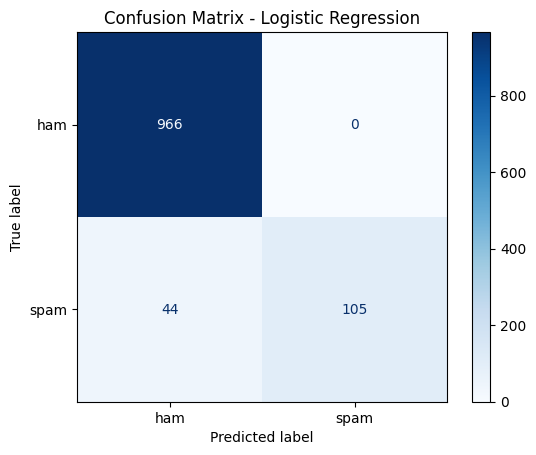

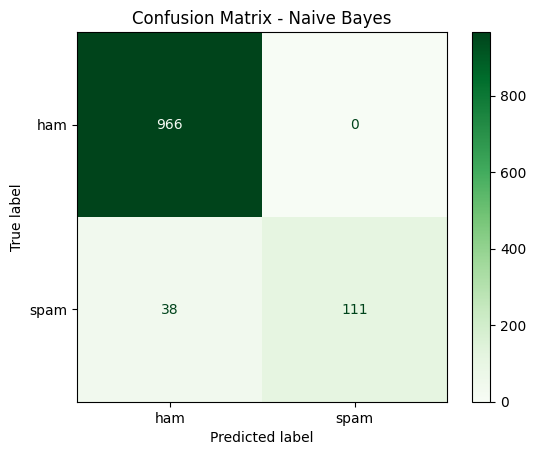

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Logistic Regression Confusion Matrix
cm_log = confusion_matrix(y_test, y_pred_log, labels=["ham", "spam"])
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=["ham", "spam"])
disp_log.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Naive Bayes Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=["ham", "spam"])
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=["ham", "spam"])
disp_nb.plot(cmap="Greens")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()
